# Time Series Utils - Forecasting example

###### Sales dataset (Kaggle)  https://www.kaggle.com/c/competitive-data-science-predict-future-sales

### 0 - Setup

###### Import pckgs 

In [8]:
from ts_utils import *
import warnings
warnings.filterwarnings("ignore")

###### Import data

In [9]:
dtf = pd.read_csv('data.csv')
dtf.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [10]:
dtf["date"] = pd.to_datetime(dtf['date'], format='%d.%m.%Y')

In [11]:
ts = dtf.groupby("date")["item_cnt_day"].sum().rename("sales")
ts.head()

date
2013-01-01    1951.0
2013-01-02    8198.0
2013-01-03    7422.0
2013-01-04    6617.0
2013-01-05    6346.0
Name: sales, dtype: float64

In [12]:
ts.tail()

date
2015-10-27    1551.0
2015-10-28    3593.0
2015-10-29    1589.0
2015-10-30    2274.0
2015-10-31    3104.0
Name: sales, dtype: float64

### 1 - TimeSeries Analysis

###### Check for:
- Trend 
- Outliers
- Stationarity
- Seasonality (define s)

###### Target Variable

In [52]:
print("population --> len:", len(ts), "| mean:", round(ts.mean()), " | std:", round(ts.std()))
w = 30
print("moving --> len:", w, " | mean:", round(ts.ewm(span=w).mean()[-1]), " | std:", round(ts.ewm(span=w).std()[-1]))

population --> len: 1034 | mean: 3528.0  | std: 1585.0
moving --> len: 30  | mean: 2305.0  | std: 773.0


###### Trend

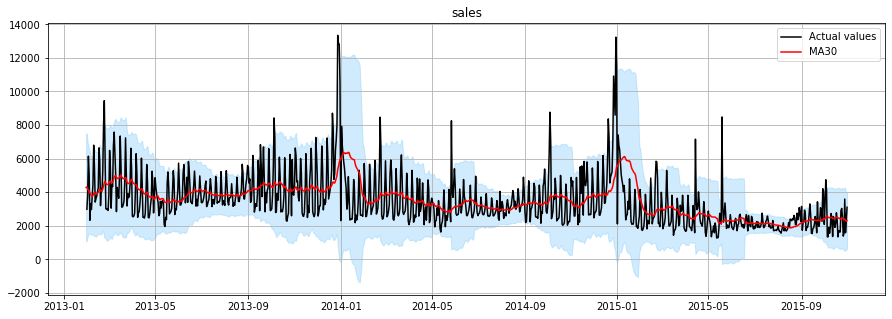

In [54]:
plot_ts(ts, plot_ma=True, plot_intervals=True, window=w, figsize=(15,5))

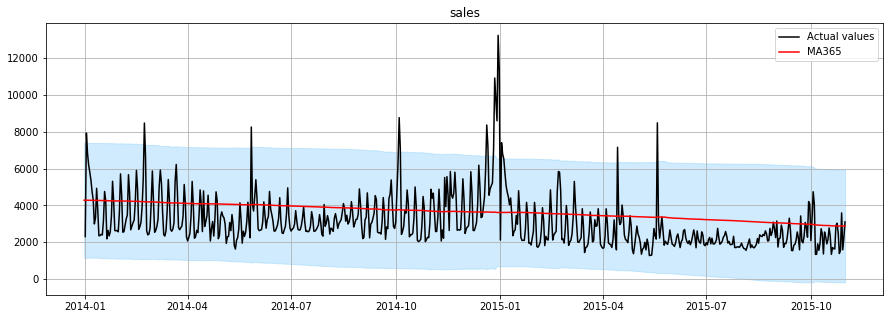

In [39]:
# looks like a soft downtrend, it should be clear with a window of 1 year
plot_ts(ts, plot_ma=True, plot_intervals=True, window=365, figsize=(15,5))

In [ ]:
# -> I will use a linear ("additive") trend

###### Outliers

In [ ]:
# -> I will keep the outliers.

###### Stationarity

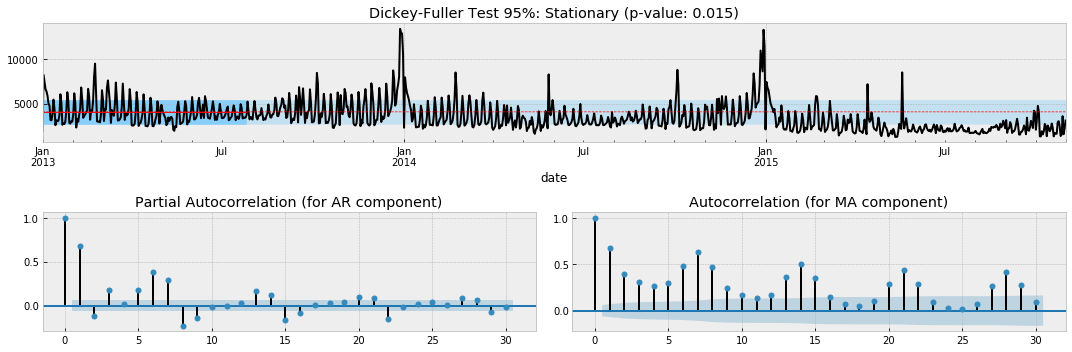

In [55]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=w, figsize=(15,5))

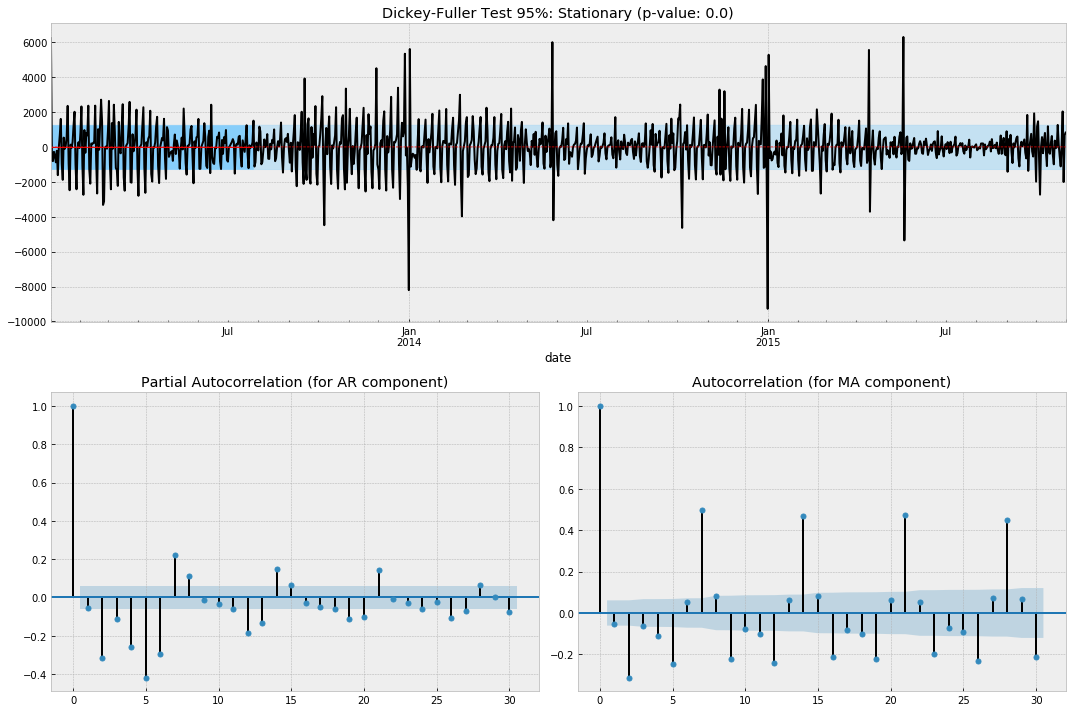

In [59]:
# I'm not sure: the test says it's stationary but it doesn't look like, let's try with differentiating the ts
test_stationarity_acf_pacf(diff_ts(ts, order=1), sample=0.20, maxlag=30, figsize=(15,10))

In [ ]:
# CLearly there is stationarity every 2 days (negative: at the beginning of the week less sales) 
# and 7 days (positive: more sales on the weekend)
# -> I will use the raw ts.

###### Seasonality

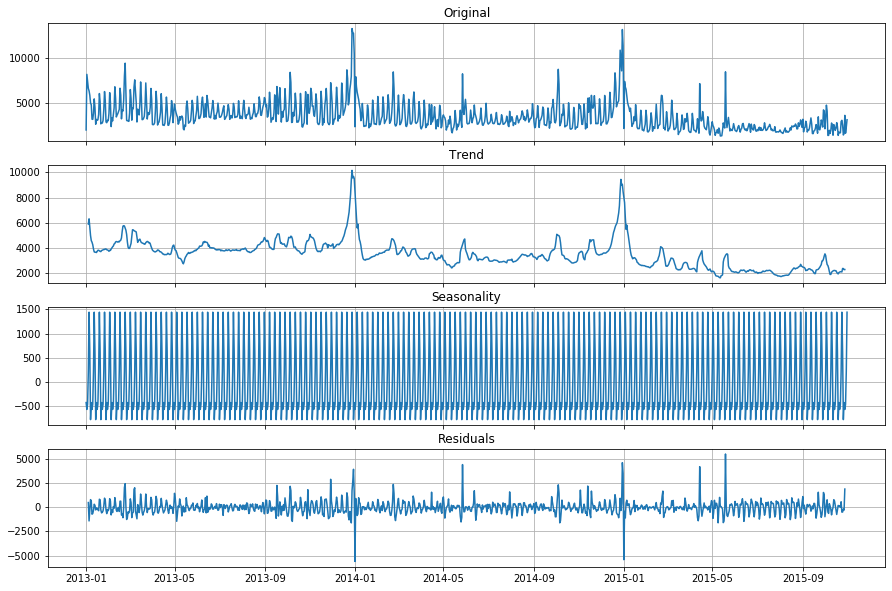

In [64]:
dic_decomposed = decompose_ts(ts, s=7, figsize=(15,10))

In [ ]:
# -> Using weekly seasonality there are smaller residuals
s = 7

### 2 - Preprocessing

### 3 - Baseline (Random walk)

--- splitting at index:  827  ---


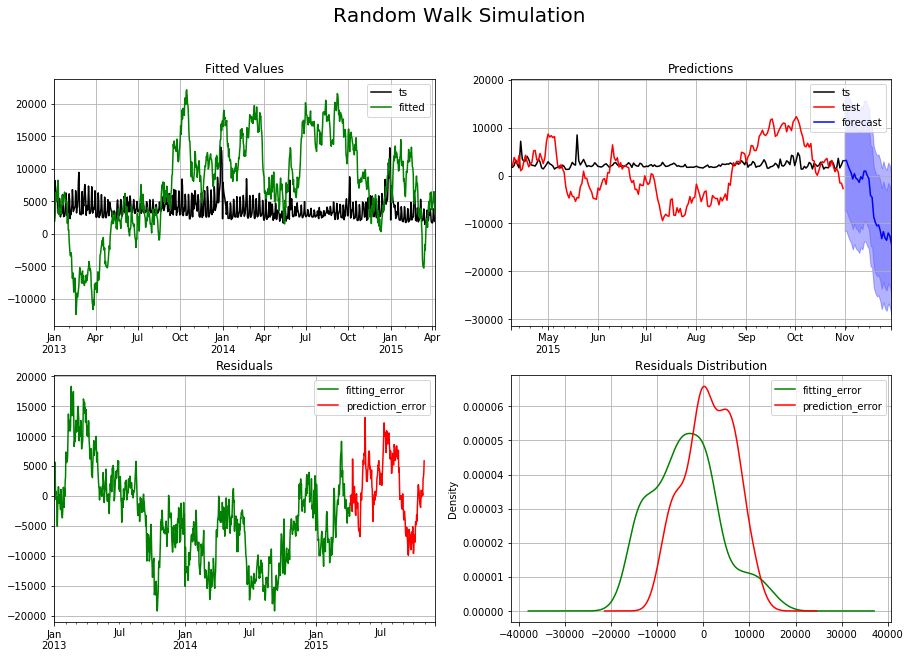

error_mean: 1286.0  | error_std: 5356.0  | mae: 4523.0  | mape: 215.0 %  | mse: 30203021.0  | rmse: 5496.0


In [320]:
randomwalk = simulate_randomwalk(ts, test=0.2, pred_ahead=30, figsize=(15,10))

### 4 - Model Desing & Testing (Autoregressive)

###### Smoothing

Seasonal parameters: multiplicative Seasonality every 7 observations
--- splitting at index:  827  ---


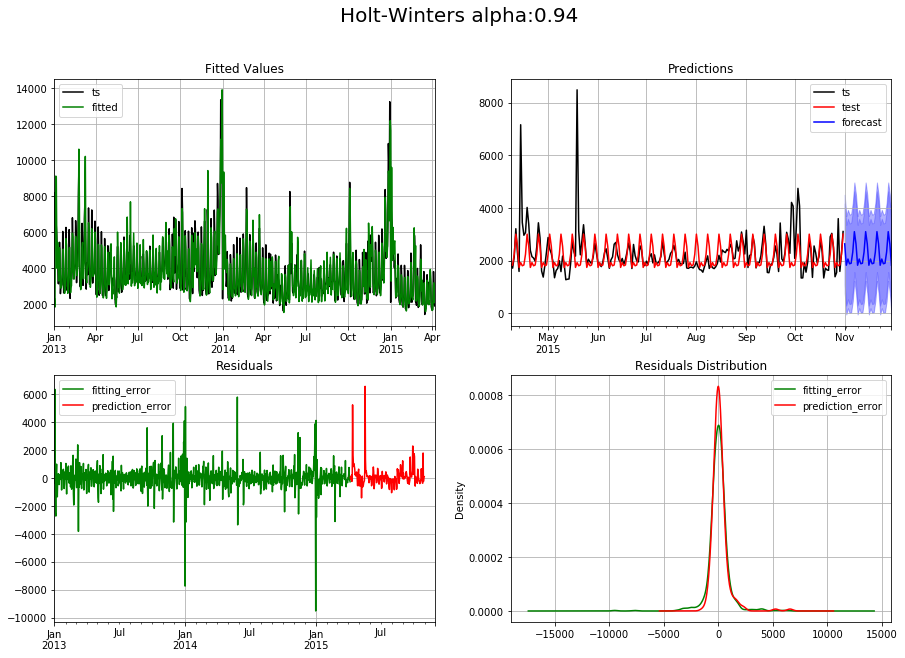

error_mean: 118.0  | error_std: 781.0  | mae: 421.0  | mape: 16.0 %  | mse: 621616.0  | rmse: 788.0


In [23]:
holtwinters, model = fit_expsmooth(ts, trend="additive", seasonal="multiplicative", s=s, alpha=0.94, test=0.2, 
                                   pred_ahead=30, figsize=(15,10))

###### SarimaX

In [11]:
# this takes a while
find_best_sarimax(ts, seasonal=True, stationary=False, s=s, exog=None,
                  max_p=10, max_d=3, max_q=10, 
                  max_P=1, max_D=1, max_Q=1)

best model --> (p, d, q): (7, 1, 7)  and  (P, D, Q, s): (0, 0, 1, 30)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1034
Model:             SARIMAX(7, 1, 7)x(0, 0, 1, 30)   Log Likelihood               -8468.803
Date:                            Tue, 04 Feb 2020   AIC                          16971.607
Time:                                    13:38:11   BIC                          17055.591
Sample:                                         0   HQIC                         17003.476
                                           - 1034                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -5.1555     17.925     -0.288      0.774     -40.287      29.976
ar.L1         -0.3738      0.042     -8.912      0.000      -0.456      -0.292
ar.L2         -0.3915      0.035    -11.309      0.000      -0.459      -0.324
ar.L3         -0.3883      0.040     -9.823      0.000      -0.466      -0.311
ar.L4         -0.3803      0.036    -10.663      0.000      -0.450      -0.310
ar.L5         -0.4022      0.036    -11.252      0.000      -0.472      -0.332
ar.L6         -0.3659      0.039     -9.368      0.000      -0.442      -0.289
ar.L7          0.5872      0.032     18.589      0.000       0.525       0.649
ma.L1          0.0378      0.039      0.960      0.337      -0.039       0.115
ma.L2          0.0379      0.032      1.193      0.233      -0.024       0.100
ma.L3          0.0705      0.031      2.249      0.025       0.009       0.132
ma.L4          0.0170      0.032      0.529      0.597      -0.046       0.080
ma.L5          0.0590      0.037      1.585      0.113      -0.014       0.132
ma.L6          0.0245      0.036      0.674      0.500      -0.047       0.096
ma.L7         -0.8046      0.032    -25.485      0.000      -0.867      -0.743
ma.S.L30      -0.0145      0.045     -0.319      0.750      -0.103       0.075
sigma2      8.005e+05      0.008   1.05e+08      0.000       8e+05       8e+05
===================================================================================
Ljung-Box (Q):                       52.64   Jarque-Bera (JB):             14317.90
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.56e+22. Standard errors may be unstable.
"""

Trend parameters: trend is ct and d=1
Seasonal parameters: Seasonality every 7 observations
Exog parameters: Not given
--- splitting at index:  827  ---


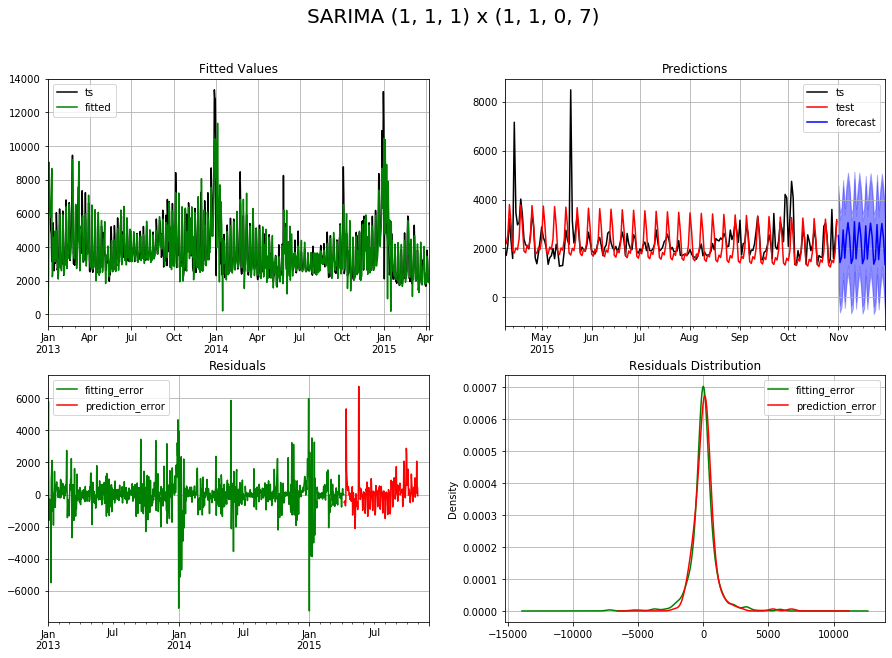

error_mean: 120.0  | error_std: 895.0  | mae: 536.0  | mape: 21.0 %  | mse: 811465.0  | rmse: 901.0


In [71]:
arima, model = fit_sarimax(ts, order=(1,1,1), seasonal_order=(1,1,0,s), test=0.2, pred_ahead=30, figsize=(15,10),
                           exog=None, pred_exog=None)

### 5 - Model Desing & Testing (Garch)

In [321]:
import arch

In [ ]:
arima = smt.ARIMA(ts_train, order=order).fit()

In [323]:
garch = arch.arch_model(ts, p=1, o=0, q=1, dist='StudentsT', power=2.0, mean='Constant', vol='GARCH')
model = garch.fit(update_freq=7)

Iteration:      7,   Func. Count:     53,   Neg. LLF: 8929.430176818194
Iteration:     14,   Func. Count:    102,   Neg. LLF: 8925.092874444514
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8924.77439956483
            Iterations: 16
            Function evaluations: 128
            Gradient evaluations: 16


In [341]:
model

1034

In [325]:
preds = model.forecast(horizon=30)

In [328]:
preds.variance

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 6 - Model Desing & Testing (Neural network)

--- splitting at index:  827  ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 260       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 266
Trainable params: 266
Non-trainable params: 0
_________________________________________________________________
None
--- training ---


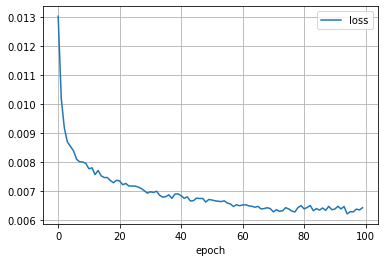

--- testing ---


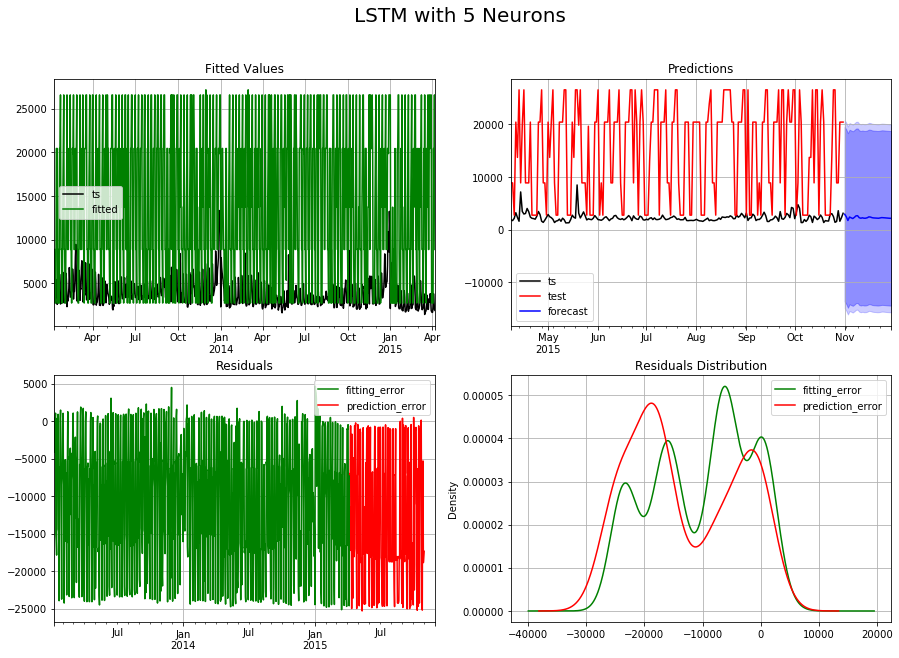

error_mean: -13090.0  | error_std: 9110.0  | mae: 13101.0  | mape: 613.0 %  | mse: 253947406.0  | rmse: 15936.0


In [72]:
lstm, model = fit_lstm(ts, exog=None, s=s, neurons=5, batch_size=1, epochs=100, test=0.2, 
                       ahead=30, freq="D", figsize=(15,10))

### 6 - Model Desing & Testing (prophet)

In [14]:
dtf_ts = ts.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf_ts.head()

,ds,y
0,2013-01-01,1951.0
1,2013-01-02,8198.0
2,2013-01-03,7422.0
3,2013-01-04,6617.0
4,2013-01-05,6346.0


In [16]:
prophet, model = fit_prophet(dtf_ts, freq="D", preds_ahead=5, figsize=(15,10),
                             growth="linear", changepoints=None, seasonality_mode='multiplicative',
                             yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality="auto", 
                             holidays=None, lst_exog=None, pred_exog=None)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--- splitting at index:  827  ---
